In [ ]:
#My path
path = '/Users/mhalt/Desktop/DEEPLEARNINGPROJECT/Data/'

path_data = '/Users/claes/Documents/GitHub/DeepLearningProject/Data/'

#Your path  
#path = '/Users/claes/Desktop/Deep_learning/Week_6'

In [22]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the data
df = pd.read_parquet(path + 'combined_cleaned_data.parquet')

data_normalized = df.to_numpy()

# Create a custom Dataset class
class FreezerDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index]
        return x, x  # For autoencoders, input and target are the same

# Create the dataset and dataloaders
freezer_dataset = FreezerDataset(data_normalized)
batch_size = 2048
train_loader = DataLoader(freezer_dataset, batch_size=batch_size, shuffle=True)

In [4]:
import torch.nn as nn

# Define the number of features (i.e., columns in your dataset)
num_features = data_normalized.shape[1]

class AutoEncoder(nn.Module):
    def __init__(self, hidden_units, latent_features=2):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=latent_features)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=num_features)
        )

    def forward(self, x): 
        z = self.encoder(x)
        x_hat = torch.sigmoid(self.decoder(z))
        return {'z': z, 'x_hat': x_hat}

# Initialize the autoencoder model
hidden_units = 64
latent_features = 2
net = AutoEncoder(hidden_units, latent_features)
cuda = torch.cuda.is_available()

if cuda:
    net = net.cuda()

print(net)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=11, bias=True)
  )
)


In [5]:
import torch
cuda = torch.cuda.is_available()
print(f"Model is on GPU: {next(net.parameters()).is_cuda}")

Model is on GPU: True


In [6]:
import torch
import torch.optim as optim
import torch.nn as nn

# Initialize the optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=0.0005)
loss_function = nn.MSELoss()

num_epochs = 10
train_loss = []

# Move the model to the GPU if available
if cuda:
    net = net.cuda()

for epoch in range(num_epochs):
    batch_loss = []
    net.train()
    
    for x, _ in train_loader:
        # Move input data to GPU if available
        if cuda:
            x = x.cuda()
        
        # Forward pass
        outputs = net(x)
        x_hat = outputs['x_hat']
        
        # Compute the loss
        loss = loss_function(x_hat, x)
        
        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Store the batch loss
        batch_loss.append(loss.item())
    
    train_loss.append(np.mean(batch_loss))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss[-1]:.4f}")

Epoch 1/10, Loss: 0.0088
Epoch 2/10, Loss: 0.0028
Epoch 3/10, Loss: 0.0022
Epoch 4/10, Loss: 0.0019
Epoch 5/10, Loss: 0.0018
Epoch 6/10, Loss: 0.0018
Epoch 7/10, Loss: 0.0017
Epoch 8/10, Loss: 0.0016
Epoch 9/10, Loss: 0.0016
Epoch 10/10, Loss: 0.0016


### Gem model

In [7]:
# Save only the model's state dictionary
model_save_path = 'autoencoder_weights.pth'
torch.save(net.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to autoencoder_weights.pth


### Hent model

In [8]:
# Create a new instance of your model
net_loaded = AutoEncoder(hidden_units=64, latent_features=2)

# Move the model to GPU if available
if cuda:
    net_loaded = net_loaded.cuda()

# Load the saved weights into the model
model_save_path = 'autoencoder_weights.pth'
net_loaded.load_state_dict(torch.load(model_save_path))
print(f"Model weights loaded from {model_save_path}")

# Set the model to evaluation mode if you are using it for inference
net_loaded.eval()

Model weights loaded from autoencoder_weights.pth


C:\Users\mhalt\AppData\Local\Temp\ipykernel_9032\1773006121.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_loaded.load_state_dict(torch.load(model_save_path))


AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=11, bias=True)
  )
)

In [9]:
import matplotlib.pyplot as plt

def detect_anomalies(data, model, threshold=0.05):
    model.eval()
    data_tensor = torch.tensor(data, dtype=torch.float32)
    
    if cuda:
        data_tensor = data_tensor.cuda()
    
    with torch.no_grad():
        outputs = model(data_tensor)
        x_hat = outputs['x_hat']
        reconstruction_error = torch.mean((data_tensor - x_hat) ** 2, dim=1).cpu().numpy()
    
    anomalies = reconstruction_error > threshold
    return anomalies, reconstruction_error

## Afprøve på træningsdata

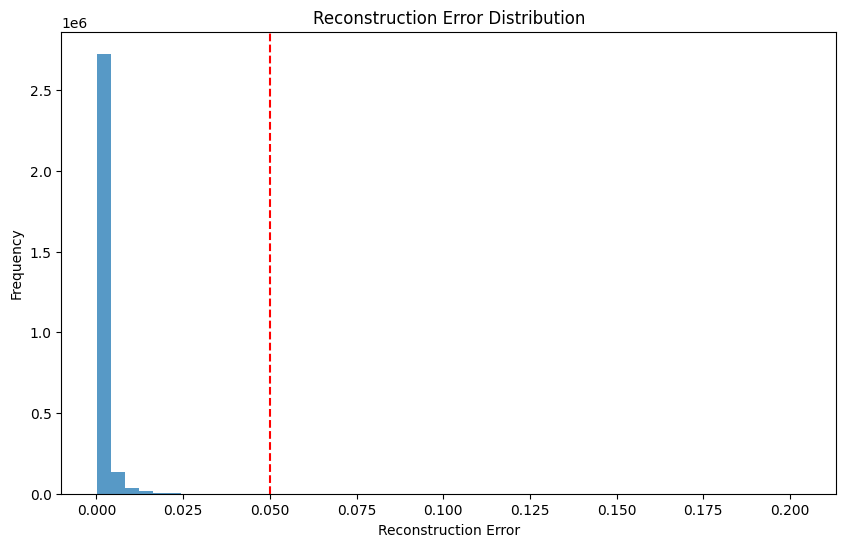

Detected 275 anomalies out of 2,923,224 samples.


In [10]:
anomalies, reconstruction_errors = detect_anomalies(data_normalized, net)

# Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.75)
plt.axvline(x=0.05, color='r', linestyle='--')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Print out the indices of anomalies
anomaly_indices = np.where(anomalies)[0]
print(f"Detected {len(anomaly_indices):,} anomalies out of {len(data_normalized):,} samples.")

In [25]:
import pandas as pd
dfDatetime = pd.read_parquet('/Users/mhalt/Desktop/DEEPLEARNINGPROJECT/Data/cleaned_data_806016.parquet')
dfDatetime

,Datetime,RTD,1st Suc.,Cond. Air In,Evap. In,Evap. Out,2nd Suc.,Chil. water In,2nd Sump,H.E.,SetPoint,Mains Voltage,State,Type,Event
0,2012-08-22 19:51:26,-70.0,-33.0,19.3,-83.0,-77.6,-44.8,23.1,48.8,-34.0,-80,227.0,3,None,None
1,2012-08-22 19:52:26,-71.3,-33.0,19.2,-83.0,-80.4,-45.7,22.7,48.7,-34.0,-80,227.0,3,None,None
2,2012-08-22 19:53:26,-72.4,-33.0,19.3,-83.0,-84.2,-46.8,22.8,48.6,-34.0,-80,228.0,3,None,None
3,2012-08-22 19:54:26,-73.1,-33.2,19.3,-83.0,-86.1,-48.0,22.5,48.5,-34.0,-80,228.0,3,None,None
4,2012-08-22 19:55:26,-74.0,-33.8,19.3,-83.0,-87.0,-49.1,22.4,48.4,-34.0,-80,228.0,3,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923219,2023-04-01 00:54:26,-80.1,-36.2,19.4,-84.3,-89.2,-54.5,26.0,28.8,-32.9,-80,224.5,3,None,None
2923220,2023-04-01 00:55:26,-80.2,-36.2,19.0,-84.4,-89.2,-54.6,25.5,28.9,-33.0,-80,225.4,3,None,None
2923221,2023-04-01 00:56:26,-80.2,-36.2,18.9,-84.4,-89.1,-54.6,25.6,28.9,-32.9,-80,225.4,3,None,None
2923222,2023-04-01 00:57:26,-80.3,-36.2,18.9,-84.4,-89.3,-54.7,26.2,28.9,-33.1,-80,224.9,3,None,None


In [30]:
pd.DataFrame(reconstruction_errors, columns=["Error"])

,Error
0,0.038700
1,0.036945
2,0.044976
3,0.056901
4,0.055662
...,...
2923219,0.000461
2923220,0.000395
2923221,0.000362
2923222,0.000556


In [33]:
dfDatetime = pd.read_parquet('/Users/mhalt/Desktop/DEEPLEARNINGPROJECT/Data/cleaned_data_806016.parquet')
df["Datetime"] = dfDatetime["Datetime"]
df["Error"] = pd.DataFrame(reconstruction_errors, columns=["Error"])

In [32]:
df

,RTD,1st Suc.,Cond. Air In,Evap. In,Evap. Out,2nd Suc.,Chil. water In,2nd Sump,H.E.,SetPoint,Mains Voltage,Datetime,Error
0,1.000000,0.158068,0.525714,0.182540,0.612903,0.332715,0.444640,1.000000,0.145270,0.0,0.666667,2012-08-22 19:51:26,0.038700
1,0.886957,0.158068,0.520000,0.182540,0.500000,0.324374,0.437610,0.996700,0.145270,0.0,0.666667,2012-08-22 19:52:26,0.036945
2,0.791304,0.158068,0.525714,0.182540,0.346774,0.314180,0.439367,0.993399,0.145270,0.0,0.698113,2012-08-22 19:53:26,0.044976
3,0.730435,0.155873,0.525714,0.182540,0.270161,0.303058,0.434095,0.990099,0.145270,0.0,0.698113,2012-08-22 19:54:26,0.056901
4,0.652174,0.149286,0.525714,0.182540,0.233871,0.292864,0.432337,0.986799,0.145270,0.0,0.698113,2012-08-22 19:55:26,0.055662
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923219,0.121739,0.122942,0.531429,0.156746,0.145161,0.242817,0.495606,0.339934,0.163851,0.0,0.588050,2023-04-01 00:54:26,0.000461
2923220,0.113043,0.122942,0.508571,0.154762,0.145161,0.241891,0.486819,0.343234,0.162162,0.0,0.616352,2023-04-01 00:55:26,0.000395
2923221,0.113043,0.122942,0.502857,0.154762,0.149194,0.241891,0.488576,0.343234,0.163851,0.0,0.616352,2023-04-01 00:56:26,0.000362
2923222,0.104348,0.122942,0.502857,0.154762,0.141129,0.240964,0.499121,0.343234,0.160473,0.0,0.600629,2023-04-01 00:57:26,0.000556


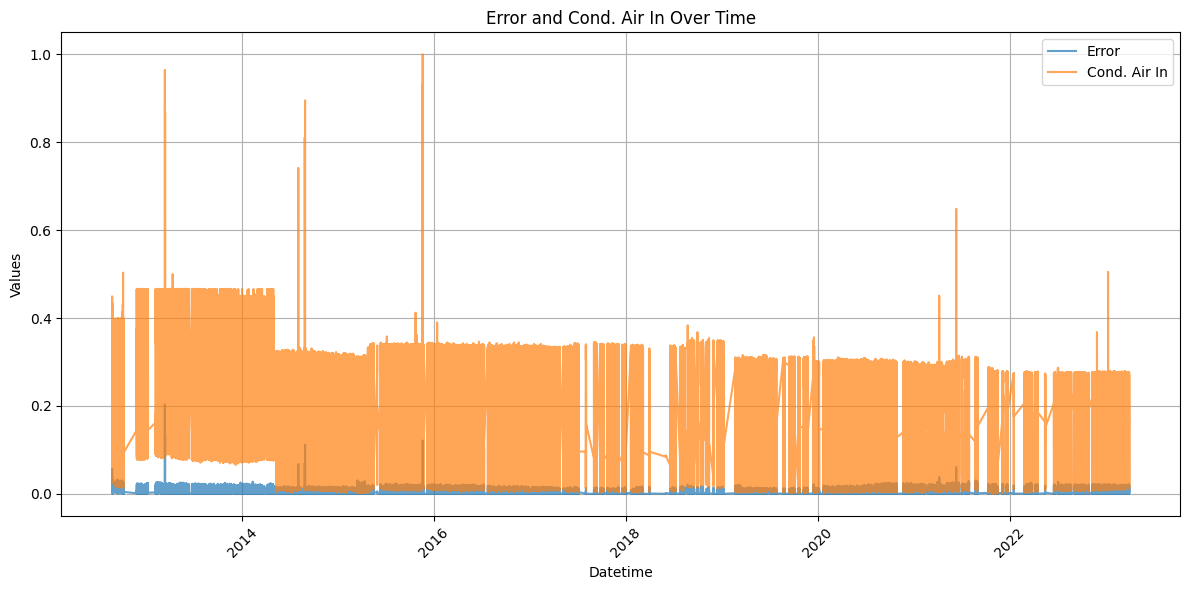

In [41]:
import matplotlib.pyplot as plt

# Konverter "Datetime"-kolonnen til datetime-format (hvis ikke allerede gjort)
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Datetime'], df['Error'], label='Error', linestyle='-', alpha=0.7)
plt.plot(df['Datetime'], df['H.E.'], label='Cond. Air In', linestyle='-', alpha=0.7)

# Tilføj labels og titel
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.title('Error and Cond. Air In Over Time')
plt.legend()
plt.grid(True)

# Formater x-aksen for bedre læsbarhed
plt.xticks(rotation=45)

# Juster layout
plt.tight_layout()

# Vis grafen
plt.show()


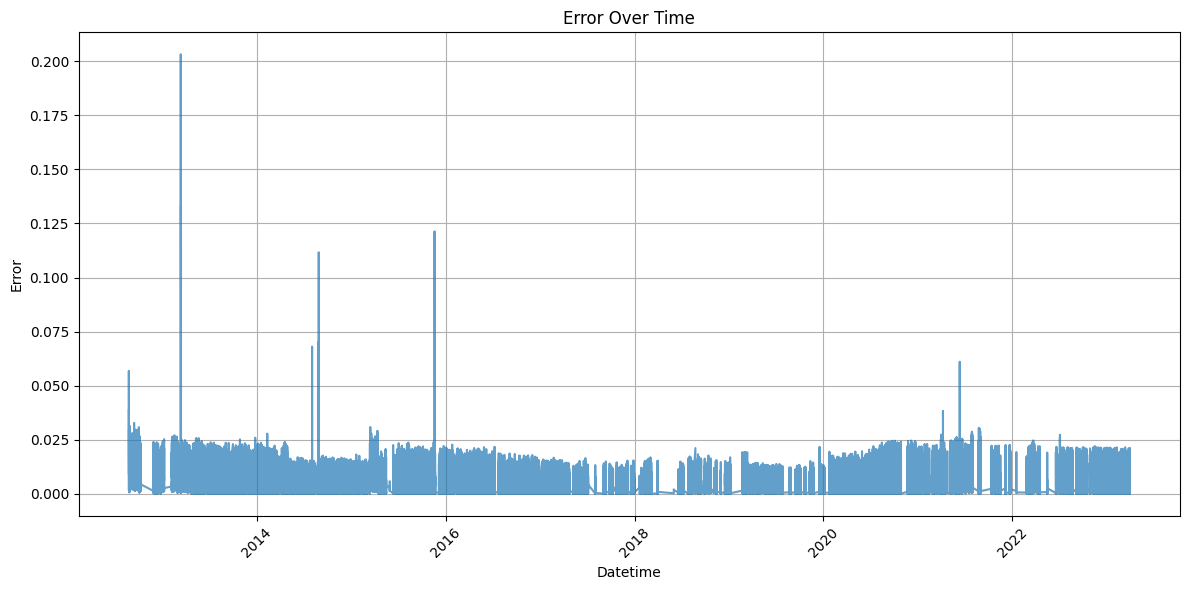

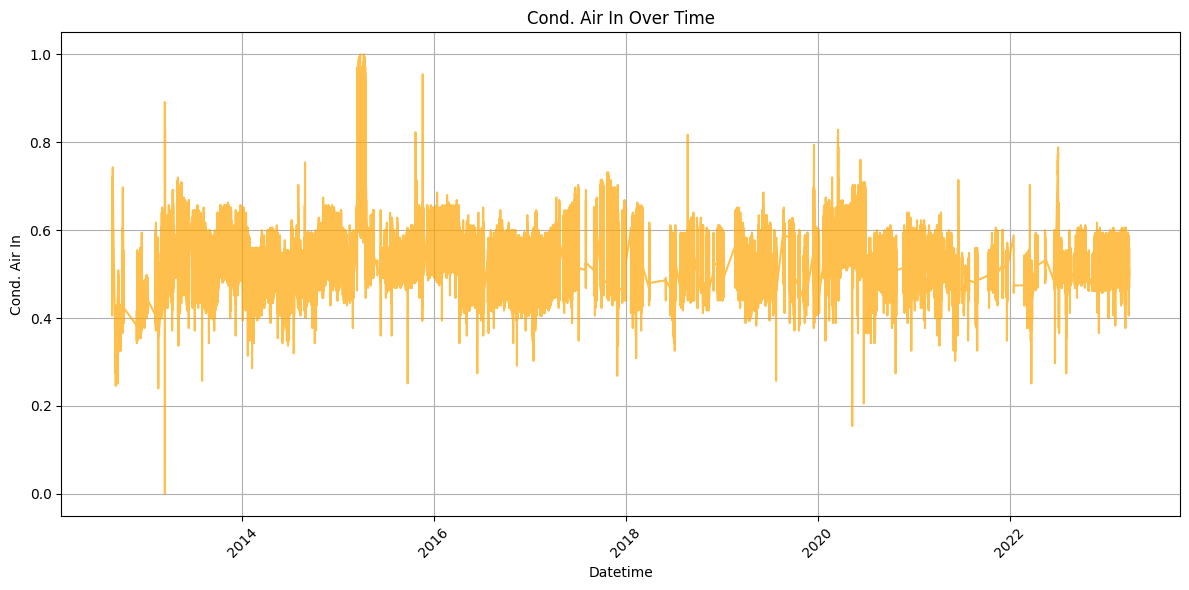

In [39]:
import matplotlib.pyplot as plt

# Konverter "Datetime"-kolonnen til datetime-format (hvis ikke allerede gjort)
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Plot for "Error"
plt.figure(figsize=(12, 6))
plt.plot(df['Datetime'], df['Error'], label='Error', linestyle='-', alpha=0.7)
plt.xlabel('Datetime')
plt.ylabel('Error')
plt.title('Error Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for "Cond. Air In"
plt.figure(figsize=(12, 6))
plt.plot(df['Datetime'], df['Cond. Air In'], label='Cond. Air In', linestyle='-', alpha=0.7, color='orange')
plt.xlabel('Datetime')
plt.ylabel('Cond. Air In')
plt.title('Cond. Air In Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Afprøve på valid sæt

In [19]:
# Step 1: Load the data
df = pd.read_parquet(path + 'around_events_data_806018.parquet')
#df = pd.read_parquet('around_events_data_806018.parquet')

# Step 2: Preprocess the data
#df.drop(columns=['Datetime', 'State', 'Type', 'Event'], inplace=True)
df.drop(columns=['Datetime', 'State', 'Type', 'Event', 'main_fault'], inplace=True)

# Step 3: Normalize the data
scaler = MinMaxScaler()
valid_data_normalized = scaler.fit_transform(df)

# Example: Detect anomalies on the training data
anomalies, reconstruction_errors = detect_anomalies(valid_data_normalized, net)

# Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.75)
plt.axvline(x=0.05, color='r', linestyle='--')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Print out the indices of anomalies
anomaly_indices = np.where(anomalies)[0]
percentage_accuracy = (len(anomaly_indices) / len(valid_data_normalized)) * 100
print(f"Detected {len(anomaly_indices):,} anomalies out of {len(valid_data_normalized):,} samples.")
print(f"Accuracy percentage: {percentage_accuracy:.2f}%")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mhalt/Desktop/DEEPLEARNINGPROJECT/Data/around_events_data_806018.parquet'